In [31]:
import os,argparse
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torchvision
import cv2 as cv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import math
from torch.autograd import Variable

from un_tar import un_tar

In [2]:
import dlib

In [14]:
# Hyperparameters
pictures_width = 224
pictures_hight = 224
sample_num=4000
num_epochs = 200
train_batch_size = 16
learning_rate= 0.0001
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]


In [9]:
if (os.path.exists("genki4k_dataloader_files")!=True):
    un_tar("genki4k.tar","genki4k_dataloader")

In [15]:
# transform 处理
# 读取图片 ，并将图片的寸尺调整至一样，这样才能进行训练
# 有很多方法实现维度一致，可以padding，可以crop，可以直接resize
# up to you to design
pictures_path=['crop_img/file{}.jpg'.format(str(i).zfill(4)) for i in range(1,4001)]
image_data=torch.Tensor(4000,3,pictures_width,pictures_hight)
lt = []
for i in range(0,4000):
    img = cv.imread(pictures_path[i])
    lt.append(img)
# 数据可以做一些预处理，比如normalization，归一化，甚至是做一些翻转旋转拉伸
# 依旧是up to you to design
im_tf= transforms.Compose([transforms.ToPILImage(),  
                           transforms.Resize((pictures_width,pictures_hight)),
                           transforms.ToTensor()])
for i in range(0,4000):
    image_data[i]=im_tf(lt[i])
    
    
# 读取label
label_data = np.genfromtxt("genki4k_dataloader_files/labels.txt")  # 将文件中数据加载到data数组里

In [20]:
# 数据集label 需要先打乱，可以先生成一个打乱的序号
# 一开始可以先用部分样本测试模型效果，所以这里增加了一个切片

index = np.array(range(0,4000))
np.random.shuffle(index)
index = index[0:sample_num]

In [5]:
#定义dataset，dataset类将数据与标签整合，方便输入进模型，一般与dataloader一同使用
class imageDataset(Dataset):
    def __init__(self,x_data,y_data):
        self.x_data=x_data
        self.y_data=torch.from_numpy(y_data[:,0])
        self.len=x_data.shape[0]
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    def __len__(self):
        return self.len

In [6]:
#定义dataloader，装载数据给模型
train_dataset=imageDataset(x_data=image_data[index[0:int(sample_num*0.8)]],y_data=label_data[index[0:int(sample_num*0.8)]])
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=train_batch_size,
                          shuffle=True)
val_dataset=imageDataset(x_data=image_data[index[int(sample_num*0.8):int(sample_num*0.9)]],y_data=label_data[index[int(sample_num*0.8):int(sample_num*0.9)]])
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=32,
                          shuffle=True)
test_dataset=imageDataset(x_data=image_data[index[int(sample_num*0.9):sample_num]],y_data=label_data[index[int(sample_num*0.9):sample_num]])
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          shuffle=True)

In [7]:
# 定义模型框架，这里只是定义了module 类，实际模型还没生成，得调用这个类才会生成模型
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 维度 [3, 160, 160]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),  # [32, 160, 160]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  # [64, 80, 80]

            nn.Conv2d(32, 64, 3, 1, 1),  # [64, 80, 80]
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, 1, 1),  # [128, 80, 80]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  # [128, 40, 40]

            nn.Conv2d(128, 256, 3, 1, 1),  # [256, 40, 40]
            nn.BatchNorm2d(256),
            nn.ReLU(),

        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 40 * 40, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 256*40*40)
        y = self.fc(x)
        return y

In [7]:
# 定义模型框架，这里只是定义了module 类，实际模型还没生成，得调用这个类才会生成模型
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

In [8]:
#开始训练模型
model = CustomResNet18(2)
model = model.cuda()
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_epochs_loss = []
val_epochs_loss = []
train_epochs_acc = []
val_epochs_acc = []
for epoch in range(num_epochs):
    model.train()
    train_epoch_loss = []
    acc, nums = 0, 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        outputs = model(inputs)
        labels = labels.cuda()
        labels = labels.long()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        #         print(labels)
        #         print(outputs.max(axis=1)[1])
        acc += sum(outputs.max(axis=1)[1] == labels)
        nums += labels.size()[0]
        # print("train acc = {:.3}%".format(100 * sum(outputs.max(axis=1)[1] == labels) / labels.size()[0]))
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    train_epochs_loss.append(np.average(train_epoch_loss))
    train_epochs_acc.append(100 * acc / nums)
    with torch.no_grad():
        model.eval()
        acc, nums = 0, 0
        val_epoch_loss = []
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            labels = labels.long()
            loss = criterion(outputs, labels)
            val_epoch_loss.append(loss.item())
            acc += sum(outputs.max(axis=1)[1] == labels)
            #             print(labels)
            #             print(outputs.max(axis=1)[1])
            nums += labels.size()[0]
        val_epochs_loss.append(np.average(val_epoch_loss))
        val_epochs_acc.append(100 * acc / nums)
        print("epoch = {}, valid acc = {:.2f}%, loss ={}".format(epoch + 1, 100 * acc / nums,
                                                                    np.average(val_epoch_loss)))
print("Training complete!")

# test the model
acc, nums = 0, 0
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    labels = labels.long()
    loss = criterion(outputs, labels)
    #     print(labels)
    #     print(outputs.max(axis=1)[1])
    acc += sum(outputs.max(axis=1)[1] == labels)
    nums += labels.size()[0]
print("test acc = {:.3}%".format(100 * acc / nums))

# Save the model
torch.save(model.state_dict(), 'Simple_CNN.pth')

d:\anaconda\envs\dlib\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\dlib\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/200], Step [10/200], Loss: 0.6813
Epoch [1/200], Step [20/200], Loss: 0.9294
Epoch [1/200], Step [30/200], Loss: 0.3572
Epoch [1/200], Step [40/200], Loss: 0.1479
Epoch [1/200], Step [50/200], Loss: 0.8085
Epoch [1/200], Step [60/200], Loss: 0.5097
Epoch [1/200], Step [70/200], Loss: 0.5771
Epoch [1/200], Step [80/200], Loss: 0.4672
Epoch [1/200], Step [90/200], Loss: 0.8815
Epoch [1/200], Step [100/200], Loss: 0.5539
Epoch [1/200], Step [110/200], Loss: 0.6234
Epoch [1/200], Step [120/200], Loss: 0.2323
Epoch [1/200], Step [130/200], Loss: 0.2308
Epoch [1/200], Step [140/200], Loss: 0.3378
Epoch [1/200], Step [150/200], Loss: 0.5594
Epoch [1/200], Step [160/200], Loss: 0.1593
Epoch [1/200], Step [170/200], Loss: 0.1828
Epoch [1/200], Step [180/200], Loss: 0.3286
Epoch [1/200], Step [190/200], Loss: 0.3549
Epoch [1/200], Step [200/200], Loss: 0.3659
epoch = 1, valid acc = 84.50%, loss =0.3386367983542956
Epoch [2/200], Step [10/200], Loss: 0.1236
Epoch [2/200], Step [20/200], 

KeyboardInterrupt: 

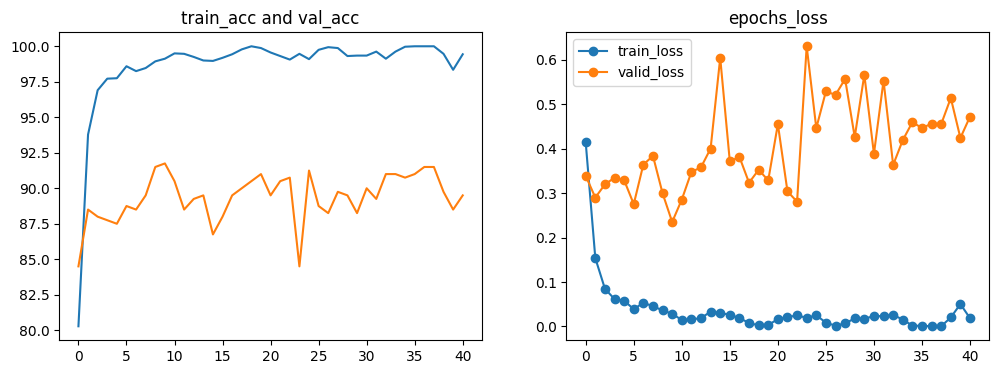

In [9]:
#最后画图
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
train=[]
val=[]
for i in range(len(train_epochs_acc)):
    train.append(train_epochs_acc[i].cpu())
for i in range(len(val_epochs_acc)):
    val.append(val_epochs_acc[i].cpu())

plt.plot(train[:])
plt.plot(val[:])
plt.title("train_acc and val_acc")
plt.subplot(1,2,2)
plt.plot(train_epochs_loss, '-o', label="train_loss")
plt.plot(val_epochs_loss, '-o', label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.show()
